# roAp Classification using regression techniques:
    ~ The classification uses a threshold value of 1.5 for all the regressions
### Updates:
* initial: (03/2/2023)
* linear regression: (04/4/2023)
* classification: (04/13/2023)
* polynomial regression classification: (04/18/22023)
* added lasso regression classification: (04/19/2023)
### Needed:
* add poly to generic and FOV plot w roAp and cluster, just to see what's up
* finish project off with adding elastic-net regression and possibly doing a learning curve
* logistic regression possibly??

In [309]:
from sklearn import neighbors, preprocessing
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, LinearRegression, Lasso, ElasticNet
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

### 1. Importing csv files containing NGC 2264 and known roAps
        'roAp' is the csv file including the field roAps
        'clust' is the csv file including NGC 2264 cluster stars
        'all' is the concatenated of the two

In [310]:
r = pd.read_csv('Data/field_roAp.csv', index_col=False)
c = pd.read_csv('Data/15MON_A0_FOV.csv', index_col=False)
rfeat = r.columns
cfeat = c.columns

roAp = pd.DataFrame(r)
clust = pd.DataFrame(c)
dbr = np.append(np.array(roAp), np.array(roAp), axis=1)
dbc = np.append(np.array(clust), np.array(clust), axis=1)
# Concatenating datasets to find roAp condidates in NGC 2264
all = pd.concat([roAp, clust],axis=0)
all['designation'] = all['designation'].str.replace(r'\D', '')
db = np.append(np.array(all),np.array(all),axis=1)
# Extracting features of all datasets
yr = (roAp['GMAG0']).values
yc = (clust['GMAG0']).values
xr = (roAp['BP-RP0']).values
xc = (clust['BP-RP0']).values
y = (all['GMAG0']).values
x = (all['BP-RP0']).values

print('Features:', len(yr))
print('Target:', len(yc))
print('---------')
print('Total Dataset for field roAps:', dbr.data.shape)
print('Total Dataset for NGC 2264:', dbc.data.shape)
print('Concatenated Dataset:',all.shape)
all.describe()

Features: 93
Target: 965
---------
Total Dataset for field roAps: (93, 120)
Total Dataset for NGC 2264: (965, 172)
Concatenated Dataset: (1058, 90)


,num,id,ra,RA_ICRS,dec,DE_ICRS,GMAG0,BP-RP0,ecl_lon,ecl_lat,...,grvs_mag,grvs_mag_error,logg_gspphot,mh_gspphot,phot_bp_mean_flux,phot_bp_mean_flux_error,phot_g_mean_flux,phot_g_mean_flux_error,phot_rp_mean_flux,phot_rp_mean_flux_error
count,1058.000000,1058.000000,1058.000000,1058.000000,1058.000000,1058.000000,1058.000000,1058.000000,1058.000000,1058.000000,...,127.000000,127.000000,846.000000,846.000000,9.650000e+02,965.000000,9.650000e+02,965.000000,9.650000e+02,965.000000
mean,0.087902,528.500000,109.151299,109.151289,7.478114,7.478106,3.442366,0.757858,109.771502,-13.118243,...,12.503708,0.073577,4.376956,-1.251781,2.165922e+04,74.888334,4.196140e+04,21.822412,2.990228e+04,77.776609
std,0.283286,305.562596,41.211886,41.211825,13.838901,13.838930,2.109317,0.467252,42.045784,12.764718,...,1.210838,0.063511,0.459858,1.033316,1.807347e+05,1115.473325,3.672976e+05,110.827438,2.778614e+05,1033.807892
min,0.000000,0.000000,2.127157,2.127157,-81.902104,-81.902104,-2.724406,-0.274474,2.019759,-85.377605,...,7.257843,0.005903,1.560400,-4.080400,9.493662e+01,5.431366,7.524995e+02,1.351323,7.388467e+02,6.360226
25%,0.000000,264.250000,100.119403,100.119403,9.797506,9.797506,2.154758,0.536962,100.236203,-13.265848,...,12.066604,0.029815,4.194500,-1.636250,3.390643e+02,11.071645,1.269774e+03,2.042505,1.384733e+03,12.372756
50%,0.000000,528.500000,100.244704,100.244704,9.920538,9.920538,3.409107,0.713893,100.364398,-13.137302,...,12.808246,0.062369,4.455300,-1.098800,6.898837e+02,14.236284,2.602011e+03,2.892261,2.781346e+03,15.658791
75%,0.000000,792.750000,100.431403,100.431403,10.019111,10.019111,4.361791,0.921099,100.558289,-13.049704,...,13.332334,0.105035,4.713975,-0.429025,2.274583e+03,20.523827,7.898782e+03,6.651048,8.173050e+03,24.481014
max,1.000000,1057.000000,348.317184,348.305087,58.526905,58.526905,13.284124,3.569711,336.146049,69.335987,...,14.090522,0.507102,5.158000,0.635400,4.076147e+06,34367.074000,9.490580e+06,2162.942900,7.721012e+06,31803.912000


#### ~ Plotting the initial HRD with the field roAps and NGC 2264

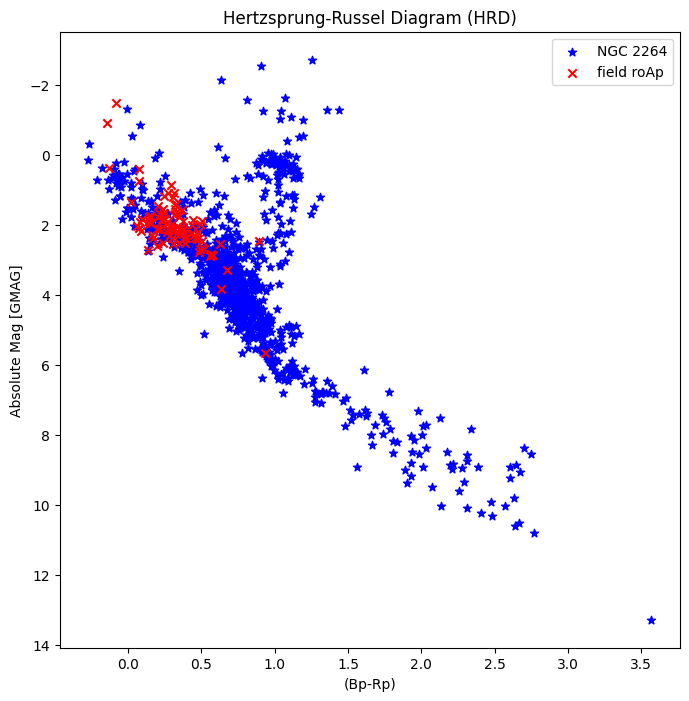

In [311]:
plt.figure(figsize=(8,8))
plt.gca().invert_yaxis()

plt.scatter(x=xc,y=yc,marker='*', c='b', label='NGC 2264')
plt.scatter(x=xr,y=yr,marker='x', c='r', label='field roAp')

plt.legend()
plt.title('Hertzsprung-Russel Diagram (HRD)')
plt.ylabel('Absolute Mag [GMAG]')
plt.xlabel('(Bp-Rp)')
plt.show()

----

### 2. Splitting the data to be used for training and showing the sizes

In [312]:
# Splitting data 80:20

xtrain, xtest, ytrain, ytest = train_test_split(db[:,np.newaxis,8],
                                                db[:,7],train_size=0.8)

xtrain_r, xtest_r, ytrain_r, ytest_r = train_test_split(dbr[:,np.newaxis,8],
                                                        dbr[:,7],train_size=0.8)

xtrain_c, xtest_c, ytrain_c, ytest_c = train_test_split(dbc[:,np.newaxis,8],
                                                        dbc[:,7],train_size=0.8)

scalar = preprocessing.StandardScaler().fit(xtrain)
xtrain = scalar.transform(xtrain)
xtest = scalar.transform(xtest)

print(f"roAp->\nTrain: {xtrain_r.shape}, Label: {ytrain_r.shape}")
print(f"Test: {xtest_r.shape}, Label: {ytest_r.shape}")
print('-----------------')
print(f"cluster->\nTrain: {xtrain_c.shape}, Label: {ytrain_c.shape}")
print(f"Test: {xtest_c.shape}, Label: {ytest_c.shape}")
print('-----------------')
print(f"Concat->\nTrain: {xtrain.shape}, Label: {ytrain.shape}")
print(f"Test: {xtest.shape}, Label: {ytest.shape}")

roAp->
Train: (74, 1), Label: (74,)
Test: (19, 1), Label: (19,)
-----------------
cluster->
Train: (772, 1), Label: (772,)
Test: (193, 1), Label: (193,)
-----------------
Concat->
Train: (846, 1), Label: (846,)
Test: (212, 1), Label: (212,)


----

### 3. Training the Linear Regression model and plotting with the HRD
        Do this but with polynomial, lets see what the cluster gives!

Coefficient for roAp or slope(m) in y = mx+b: [3.25382577]
Coefficient for cluster or slope(m) in y = mx+b: [3.10841706]

Mean squared error for roAp: 0.14
Mean squared error for cluster: 3.10

Coefficient of determination for roAp: 0.52
Coefficient of determination for cluster: 0.43


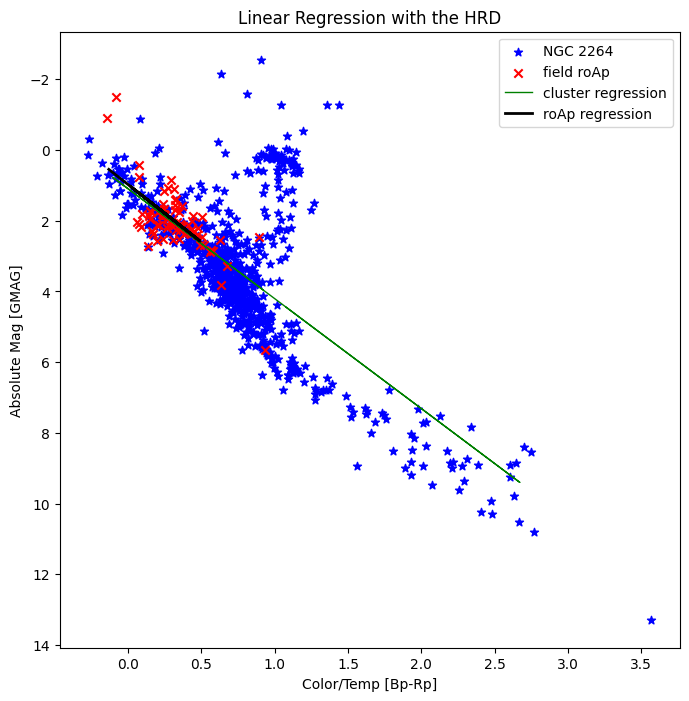

In [313]:
regr = LinearRegression()
regc = LinearRegression()
# Fitting/Training the model
regr.fit(xtrain_r,ytrain_r)
regc.fit(xtrain_c,ytrain_c)
# Predictions
data_r_pred = regr.predict(xtest_r)
data_c_pred = regc.predict(xtest_c)

# The coefficients
print(f"Coefficient for roAp or slope(m) in y = mx+b: {regr.coef_}")
print(f"Coefficient for cluster or slope(m) in y = mx+b: {regc.coef_}")
# The mean squared error
print("\nMean squared error for roAp: %.2f" % mean_squared_error(ytest_r, data_r_pred ))
print("Mean squared error for cluster: %.2f" % mean_squared_error(ytest_c, data_c_pred ))
# The coefficient of determination: 1 is perfect prediction
print("\nCoefficient of determination for roAp: %.2f" % r2_score(ytest_r, data_r_pred ))
print("Coefficient of determination for cluster: %.2f" % r2_score(ytest_c, data_c_pred ))

plt.figure(figsize=(8,8))
plt.gca().invert_yaxis()
plt.title('Linear Regression with the HRD')

plt.scatter(x=xtrain_c,y=ytrain_c,marker='*', c='b', label='NGC 2264')
plt.scatter(x=xtrain_r,y=ytrain_r,marker='x', c='r', label='field roAp')
plt.plot(xtest_c,data_c_pred,c='green',linewidth=1,label='cluster regression')
plt.plot(xtest_r,data_r_pred,c='black',linewidth=2,label='roAp regression')

plt.legend()
plt.ylabel('Absolute Mag [GMAG]')
plt.xlabel('Color/Temp [Bp-Rp]')
plt.savefig('Figures/LinearRegHRD-both')

----

### 4. Training and plotting the concatenated dataset with the linear regression

#### ~ The following shows the FOV we want to apply the regresion models to, with the cluster data:

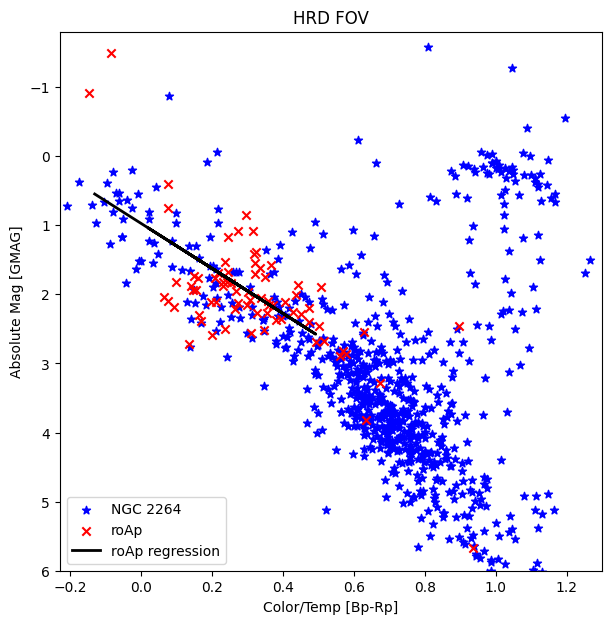

In [314]:
plt.figure(figsize=(7,7))
plt.title('HRD FOV')

plt.ylim([-1.8,6])
plt.xlim([-0.23,1.3])

plt.scatter(x=xtrain_c,y=ytrain_c,marker='*', c='b', label='NGC 2264')
plt.scatter(xtrain_r,ytrain_r,marker='x',c='r',label='roAp')
plt.plot(xtest_r,data_r_pred,c='black',linewidth=2,label='roAp regression')

plt.gca().invert_yaxis()

plt.legend()
plt.ylabel('Absolute Mag [GMAG]')
plt.xlabel('Color/Temp [Bp-Rp]')
plt.savefig('Figures/LinearRegHRD-concat.png')

#### ~ Fitting the roAp's regression to the concatenated dataset and finding the deviations:

In [315]:
# For field roAp's
regr.fit(xtrain_r,ytrain_r)
pred = regr.predict(xtrain)
predr = regr.predict(xtrain_r)

print("Regression Coefficient:", regr.coef_[0])
dist = np.abs(ytrain - pred)
print('Length of the deviation list:', len(dist))

Regression Coefficient: 3.253825768059931
Length of the deviation list: 846


#### ~ Computing which cluster stars are potential candidates using the deviations, threshold value, and the maximum B-R value:

In [316]:
print('Stars in NGC 2264 following the Linear regression:')
cands = []
thresh = 1.5
max = (xr.max()) + 0.5
for n in range(len(ytrain)):
    if (dist[n]<thresh) & (xtrain[n]<max):
        cand = clust.iloc[n]['id']
        print('Deviation:', dist[n],'| ID:',cand, '| GMAG:', ytrain[n], '| B-R: ', xtrain[n][0])
        cands.append({'ID':cand,'Deviation':dist[n],'GMAG':ytrain[n],'B-R':xtrain[n][0]})

Stars in NGC 2264 following the Linear regression:
Deviation: 0.9343277172376689 | ID: 101 | GMAG: 2.847243 | B-R:  0.28783313915663766
Deviation: 0.952554991471564 | ID: 106 | GMAG: 1.161282 | B-R:  -0.2359159475223349
Deviation: 0.9519481731507522 | ID: 120 | GMAG: 2.684662 | B-R:  0.23245173008367204
Deviation: 1.3906581611314706 | ID: 130 | GMAG: 2.803017 | B-R:  0.1339968616253257
Deviation: 1.1987142551445622 | ID: 134 | GMAG: 4.895303 | B-R:  0.8360104508006501
Deviation: 0.053690949671671095 | ID: 167 | GMAG: 2.461058 | B-R:  0.47279499938192515
Deviation: 1.4797589827590922 | ID: 177 | GMAG: 6.792743 | B-R:  1.332778067632584
Deviation: 1.277519932967076 | ID: 205 | GMAG: 1.076551 | B-R:  -0.3618280186347934
Deviation: 0.8996501447574694 | ID: 227 | GMAG: 1.2119 | B-R:  0.3488796967028251
Deviation: 1.2961510101915097 | ID: 240 | GMAG: 3.105034 | B-R:  0.2558608393564951
Deviation: 0.6963049592568655 | ID: 251 | GMAG: 2.692483 | B-R:  0.31342232675178294
Deviation: 1.169160420

### 5. Exporting potential candidates

#### ~ Writing the data to a csv file:

In [317]:
print(len(cands))
df = pd.DataFrame(cands)
df.to_csv('Data/linear-candidates.csv',index=False,header=True)
df.describe()

48


,ID,Deviation,GMAG,B-R
count,48.000000,48.000000,48.000000,48.000000
mean,472.687500,0.951713,2.715548,0.353770
std,243.780522,0.443791,1.541136,0.404898
min,101.000000,0.021291,0.094609,-0.361828
25%,257.250000,0.675494,1.807977,0.107482
50%,443.000000,0.952252,2.502419,0.325037
75%,686.250000,1.335481,3.133801,0.586154
max,933.000000,1.493656,6.837832,1.421118


#### ~ Displaying the candidates with the roAp's:

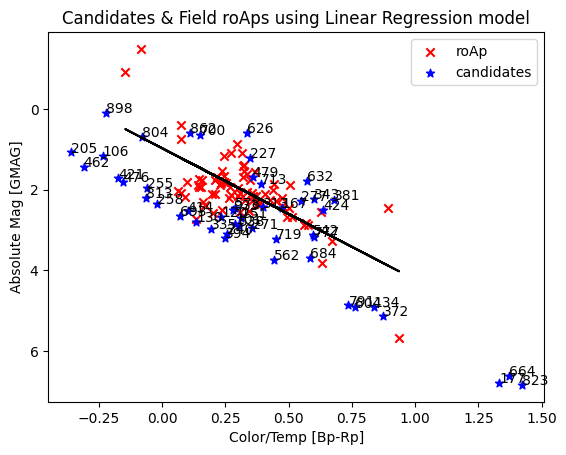

In [331]:
a1 = df['B-R']
b1 = df['GMAG']

plt.gca().invert_yaxis()
plt.title('Candidates & Field roAps using Linear Regression model')

plt.scatter(xtrain_r,ytrain_r,marker='x',c='r',label='roAp')
plt.scatter(a1,b1,marker='*',c='b',label='candidates')
plt.plot(xtrain_r,predr,c='black')

plt.ylabel('Absolute Mag [GMAG]')
plt.xlabel('Color/Temp [Bp-Rp]')
plt.legend()

for i, id in enumerate(df['ID']):
    plt.annotate(id, (a1[i],b1[i]))

plt.savefig('Figures/Linear-Candidates')
plt.show()

### 6. Showing which degree is best to fit to data for no under/over fitting

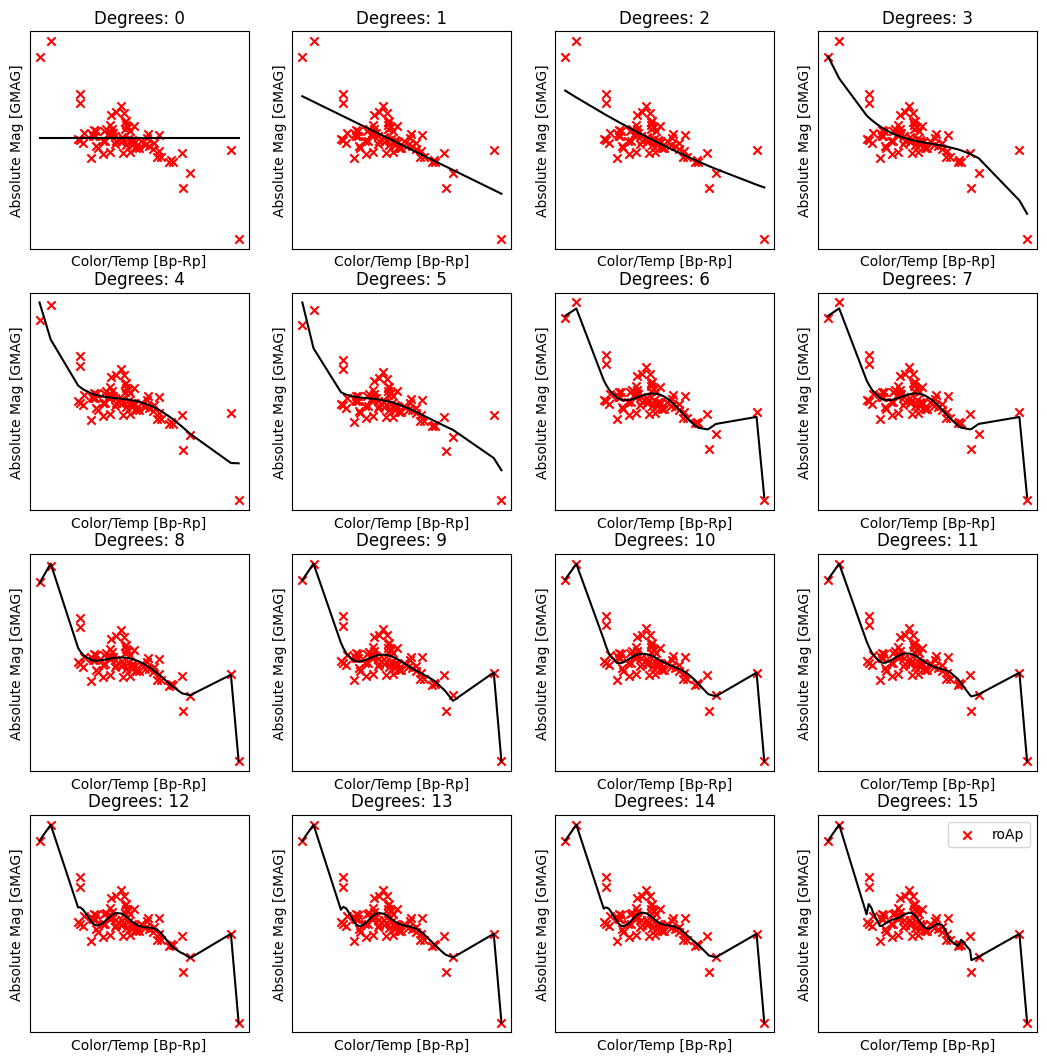

In [319]:
# Flattening the series for the x-values and prediction values
xf = pd.Series(xtrain_r.flatten())
# Sorting
xs = xf.sort_values()
# Arraning into an array to plot
xarr = np.array(xs)

plt.figure(figsize=(13,13))
for i in range(16):
    plt.subplot(4,4,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)

    polyi = PolynomialFeatures(degree=(i))
    regpi = LinearRegression()
    
    pfri = polyi.fit_transform(xtrain_r)
    pfi = polyi.fit_transform(xtrain)

    regpi.fit(pfri, ytrain_r)
    yfi = pd.Series(regpi.predict(pfri).flatten())
    ypredi = np.array(yfi[xs.index])

    plt.gca().invert_yaxis()
    plt.title(f'Degrees: {i}')
    plt.scatter(xtrain_r,ytrain_r,marker='x',c='r',label='roAp')
    plt.plot(xarr,ypredi,c='black')
    
    plt.ylabel('Absolute Mag [GMAG]')
    plt.xlabel('Color/Temp [Bp-Rp]')
    plt.savefig('Figures/ith-deg-Polynomial-roAp')
plt.legend()

### 7. Training and plottting the concatenated dataset using polynomial regression
        5 degrees being used, chosen from subplot

In [320]:
deg = 5
poly = PolynomialFeatures(degree=deg, include_bias=False)
regp = LinearRegression()

pfr = poly.fit_transform(xtrain_r)
pf = poly.fit_transform(xtrain)
regp.fit(pfr, ytrain_r)
print('')

#### ~ Predicting, calculating deviation, and exporting candidates then plotting

In [329]:
predp = regp.predict(pf)
predpr = regp.predict(pfr)

print(f'Intercept: {regp.intercept_} and Coefficients: {regp.coef_}')
print('The Mean Squared Error: %.2f' % mean_squared_error(ytrain,pred))
dist = np.abs(ytrain - predp)
print('Length of the deviation list:', len(dist))

Intercept: 1.2081722739334841 and Coefficients: [   8.99436823  -52.35061282  145.04169874 -168.62163821   71.33941305]
The Mean Squared Error: 11.86
Length of the deviation list: 846


In [322]:
print('Stars in NGC 2264 following the Polynomial regression:')
cands = []
thresh = 1.5
max = (xr.max()) + 0.5
for n in range(len(ytrain)):
    if (dist[n]<thresh) & (xtrain[n]<max):
        cand = clust.iloc[n]['id']
        print('Deviation:', dist[n],'| ID:',cand, '| GMAG:', ytrain[n], '| B-R: ', xtrain[n][0])
        cands.append({'ID':cand,'Deviation':dist[n],'GMAG':ytrain[n],'B-R':xtrain[n][0]})

Stars in NGC 2264 following the Polynomial regression:
Deviation: 0.9450554139366858 | ID: 101 | GMAG: 2.847243 | B-R:  0.28783313915663766
Deviation: 1.135699620902587 | ID: 103 | GMAG: 2.864242 | B-R:  0.10737982929563217
Deviation: 0.836575945877658 | ID: 120 | GMAG: 2.684662 | B-R:  0.23245173008367204
Deviation: 0.9143773843691267 | ID: 128 | GMAG: 6.517113 | B-R:  1.0650998022728617
Deviation: 1.0319100528806247 | ID: 130 | GMAG: 2.803017 | B-R:  0.1339968616253257
Deviation: 1.243692305947416 | ID: 134 | GMAG: 4.895303 | B-R:  0.8360104508006501
Deviation: 1.4053137644989282 | ID: 152 | GMAG: 1.366215 | B-R:  0.5970136362820493
Deviation: 0.11398765322010673 | ID: 167 | GMAG: 2.461058 | B-R:  0.47279499938192515
Deviation: 0.7919949401019402 | ID: 227 | GMAG: 1.2119 | B-R:  0.3488796967028251
Deviation: 1.2376716035144484 | ID: 240 | GMAG: 3.105034 | B-R:  0.2558608393564951
Deviation: 0.7536386724677122 | ID: 251 | GMAG: 2.692483 | B-R:  0.31342232675178294
Deviation: 1.3529970

In [323]:
print(len(cands))
dfp = pd.DataFrame(cands)
dfp.to_csv('Data/polynomial-candidates.csv',index=False,header=True)
dfp.describe()

46


,ID,Deviation,GMAG,B-R
count,46.000000,46.000000,46.000000,46.000000
mean,467.173913,0.946024,2.620364,0.381007
std,242.819577,0.388162,1.256963,0.273600
min,101.000000,0.113988,0.590921,-0.080020
25%,261.250000,0.655601,1.977397,0.160823
50%,447.500000,0.974375,2.624640,0.351306
75%,690.750000,1.278368,2.975620,0.592639
max,933.000000,1.497950,6.517113,1.065100


#### ~ Displaying graph of roAp candidates with field roAp's using 5 degree polynomial regression

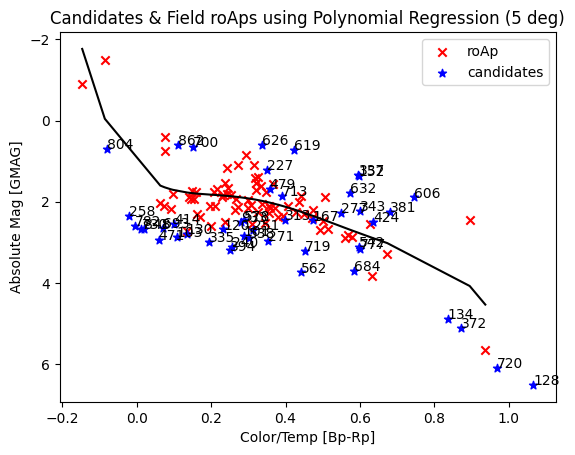

In [332]:
a2 = dfp['B-R']
b2 = dfp['GMAG']
# Flattening the series for the x-values and prediction values
xf = pd.Series(xtrain_r.flatten())
yf = pd.Series(predpr.flatten())
# Sorting
xs = xf.sort_values()
# Arraning into an array to plot
ypred = np.array(yf[xs.index])
xarr = np.array(xs)

plt.gca().invert_yaxis()
plt.title(f'Candidates & Field roAps using Polynomial Regression ({deg} deg)')

plt.scatter(xtrain_r,ytrain_r,marker='x',c='r',label='roAp')
plt.scatter(a2,b2,marker='*',c='b',label='candidates')
plt.plot(xarr,ypred,c='black')

plt.ylabel('Absolute Mag [GMAG]')
plt.xlabel('Color/Temp [Bp-Rp]')
plt.legend()

for i, id in enumerate(dfp['ID']):
    plt.annotate(id, (a2[i],b2[i]))
    
plt.savefig(f'Figures/Polynomial-Candidates-{deg}deg')
plt.show()

### 8. Training and plotting concatenated set with Lasso regression

In [325]:
lreg = Lasso(alpha=.06)

lreg.fit(xtrain_r,ytrain_r)
lpred = lreg.predict(xtrain)
lpredr = lreg.predict(xtrain_r)

print("Regression Coefficient:", lreg.coef_[0])
dist = np.abs(ytrain - lpred)
print('Length of the deviation list:', len(dist))

Regression Coefficient: 1.5233379383601329
Length of the deviation list: 846


#### ~ The slope, coefficient, is very steep, as seen in the plot. This is a discrete value, determined from $\alpha$, here it is 0.06

In [326]:
print('Stars in NGC 2264 following the Lasso regression:')
cands = []
thresh = 1.5
max = (xr.max()) + 0.5
min = (xr.min()) - 0.1
for n in range(len(ytrain)):
    if (dist[n]<thresh) & (xtrain[n]<max) & (xtrain[n]>min):
        cand = clust.iloc[n]['id']
        print('Deviation:', dist[n],'| ID:',cand, '| GMAG:', ytrain[n], '| B-R: ', xtrain[n][0])
        cands.append({'ID':cand,'Deviation':dist[n],'GMAG':ytrain[n],'B-R':xtrain[n][0]})

Stars in NGC 2264 following the Lasso regression:
Deviation: 0.883728260056408 | ID: 101 | GMAG: 2.847243 | B-R:  0.28783313915663766
Deviation: 1.1756186330703342 | ID: 103 | GMAG: 2.864242 | B-R:  0.10737982929563217
Deviation: 0.0043858860240435504 | ID: 106 | GMAG: 1.161282 | B-R:  -0.2359159475223349
Deviation: 0.8055118615770984 | ID: 120 | GMAG: 2.684662 | B-R:  0.23245173008367204
Deviation: 1.073846897915954 | ID: 130 | GMAG: 2.803017 | B-R:  0.1339968616253257
Deviation: 1.068286121015778 | ID: 152 | GMAG: 1.366215 | B-R:  0.5970136362820493
Deviation: 1.2130321290535597 | ID: 161 | GMAG: 2.684225 | B-R:  -0.03535310638985895
Deviation: 0.2157838412255635 | ID: 167 | GMAG: 2.461058 | B-R:  0.47279499938192515
Deviation: 1.414936775647396 | ID: 175 | GMAG: 2.952021 | B-R:  0.007901480623903227
Deviation: 1.4468623502111386 | ID: 194 | GMAG: 1.697933 | B-R:  1.06328852598905
Deviation: 0.8446092770599845 | ID: 227 | GMAG: 1.2119 | B-R:  0.3488796967028251
Deviation: 1.190223877

In [327]:
print(len(cands))
dfl = pd.DataFrame(cands)
dfl.to_csv('Data/linlasso-candidates.csv',index=False,header=True)
dfl.describe()

61


,ID,Deviation,GMAG,B-R
count,61.000000,61.000000,61.000000,61.000000
mean,487.672131,0.899004,2.168176,0.249691
std,245.177740,0.393308,0.798818,0.318020
min,101.000000,0.004386,0.094609,-0.235916
25%,271.000000,0.688965,1.697933,-0.020213
50%,479.000000,0.998751,2.404726,0.255861
75%,684.000000,1.175619,2.684662,0.548343
max,933.000000,1.486238,3.700664,1.063289


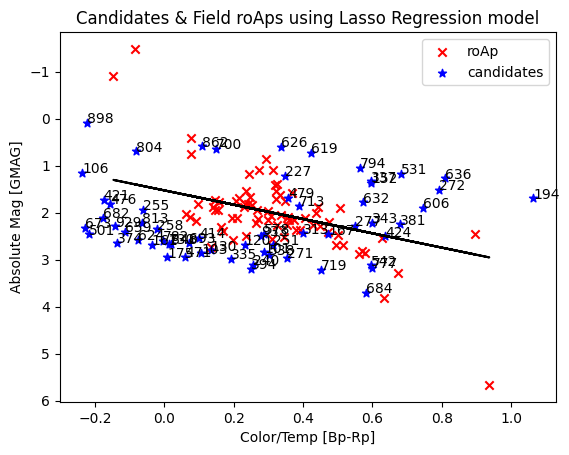

In [334]:
a3 = dfl['B-R']
b3 = dfl['GMAG']

plt.gca().invert_yaxis()
plt.title('Candidates & Field roAps using Lasso Regression model')

plt.scatter(xtrain_r,ytrain_r,marker='x',c='r',label='roAp')
plt.scatter(a3,b3,marker='*',c='b',label='candidates')
plt.plot(xtrain_r,lpredr,c='black')

plt.ylabel('Absolute Mag [GMAG]')
plt.xlabel('Color/Temp [Bp-Rp]')
plt.legend()

for i, id in enumerate(dfl['ID']):
    plt.annotate(id, (a3[i],b3[i]))
    
plt.savefig('Figures/LinearLasso-Candidates')
plt.show()

## I AM GOING TO STOP LOL, I LOVE MAKING THIS BUT I WILL LET DAVID FINSIH WITH ELASTIC NET AND PSSOIBLE SHOWING A LEARNING CURVE

### 9. Plotting and exporting all 3 regression model candidates, so we have new and repeated stars
        Still need to export the repeated and new stars; possibly a csv file for each, new, both, and all

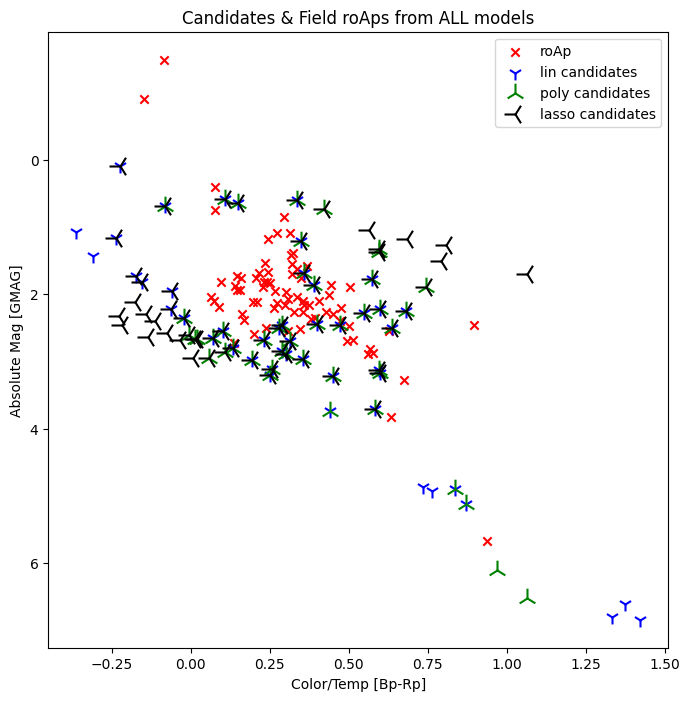

In [352]:
plt.figure(figsize=(8,8))
plt.gca().invert_yaxis()
plt.title('Candidates & Field roAps from ALL models')

plt.scatter(xtrain_r,ytrain_r,marker='x',c='r',label='roAp')
plt.scatter(a1,b1,marker='1',s=100,c='b',label='lin candidates')
plt.scatter(a2,b2,marker='2',s=200,c='g',label='poly candidates')
plt.scatter(a3,b3,marker='3',s=250,c='black',label='lasso candidates')

plt.ylabel('Absolute Mag [GMAG]')
plt.xlabel('Color/Temp [Bp-Rp]')
plt.legend()
    
plt.savefig('Figures/ALL-reg-Candidates')
plt.show()